<a href="https://colab.research.google.com/github/princeedey/PUBG/blob/master/pubg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:

##Importing necessary packages for the program

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
from pandas.api.types import is_string_dtype, is_numeric_dtype

#Unable to import fastai module. So directly imported it from the link given below.
# https://github.com/anandsaha/fastai.part1.v2/blob/master/fastai/structured.py

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
  
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2

# For notebook plotting
%matplotlib inline

# Standard libraries
import os
import numpy as np
import pandas as pd
!pip install PDPbox
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from plotnine import *
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
import sklearn
from sklearn import metrics
from scipy.cluster import hierarchy as hc
from fastai.imports import *

#Reading the data
train=pd.read_csv('gdrive/My Drive/train_V2.csv')
test=pd.read_csv('gdrive/My Drive/test_V2.csv')

     |████████████████████████████████| 57.7MB 73kB/s 
  Created wheel for PDPbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=18c9d4f2e7bec5a3ffebdd816f79371aebcb4c4542e361e7964f807a71f68aac
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built PDPbox


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Displaying the tail and head

display(train.head())
display(train.tail())

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0,0,0.000,0,0,1019.0,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0,0,0.000,0,0,81.7,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0,0,2.184,0,0,788.7,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0,0,0.000,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0,0,0.000,0,0,1244.0,5,0,0.5464


In [5]:
# Getting the stats of the data
train.describe()
train.info()
print('Shape of training set: ', train.shape)

# Check row with NaN value and then removing them
train[train['winPlacePerc'].isnull()]
train.drop(2744604, inplace=True)
train[train['winPlacePerc'].isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


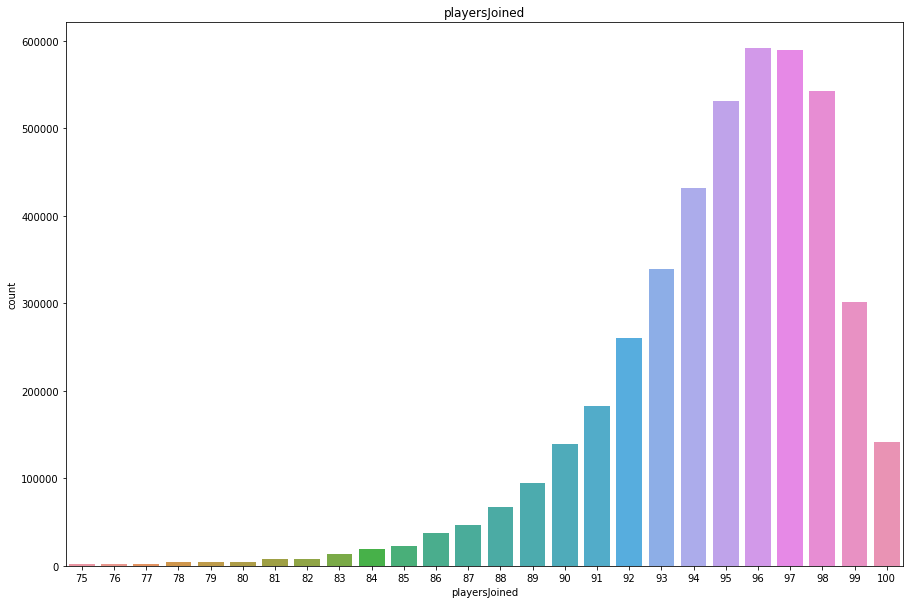

In [6]:
# Creating a bar graph of the number of players that have joined
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('playersJoined')
plt.show()

In [7]:
# Creating  normalized features and displaying them
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


In [0]:
# Create new feature healsandboosts
train['healsandboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts', 'healsandboosts']].tail()
# Create feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
# Create feature killsWithoutMoving
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))
# Create headshot_rate feature
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

In [9]:
# Check players who kills without moving and remove them
display(train[train['killsWithoutMoving'] == True].shape)
train[train['killsWithoutMoving'] == True].head(10)
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)
# Players who got more than 10 roadKills and remove them
train[train['roadKills'] > 10]
train.drop(train[train['roadKills'] > 10].index, inplace=True)

(1535, 38)

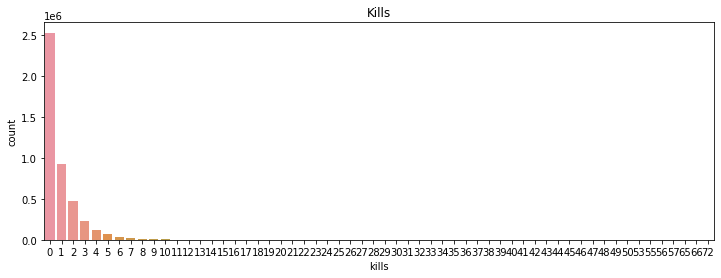

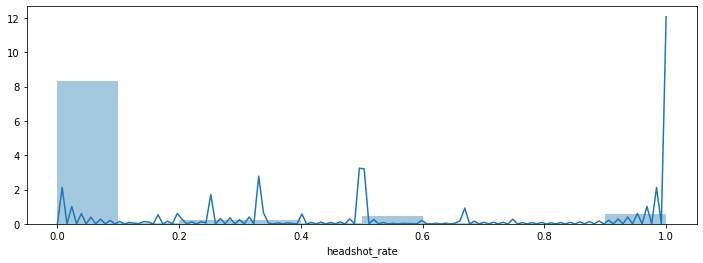

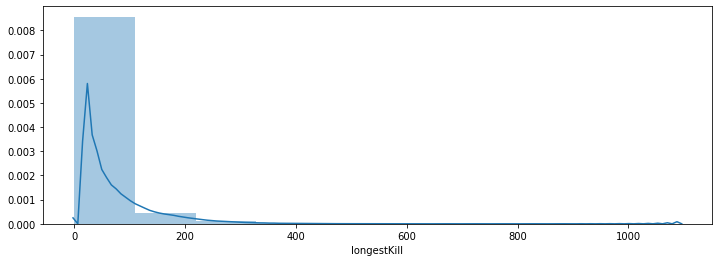

In [10]:

# Plot the distribution of kills
plt.figure(figsize=(12,4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()
# Plot the distribution of headshot_rate
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()
# Plot the distribution of longestKill
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

In [0]:
# Remove outliers
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

(21, 38)

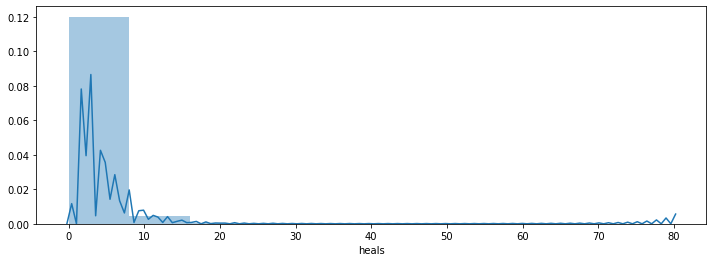

(135, 38)

(4445250, 38)

In [12]:
# Players who acquired more than 80 weapons
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)
# Distribution of heals
plt.figure(figsize=(12,4))
sns.distplot(train['heals'], bins=10)
plt.show()
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)
# Remaining players in the training set
train.shape


In [13]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))
# One hot encode matchType
train = pd.get_dummies(train, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()
# Turn groupId and match Id into categorical types
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
train.drop(columns = ['Id'], inplace=True)

There are 16 different Match types in the dataset.


In [14]:
# Take sample for debugging and exploration
sample = 500000
df_sample = train.sample(sample)
# Splitting sample into training data and target variable
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

from sklearn.metrics import mean_absolute_error
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)


Sample train shape:  (440000, 51) Sample target shape:  (440000,) Sample validation shape:  (60000, 51)
['mae train: ', 0.03940720552283221, 'mae val: ', 0.06250315599743549]


Significant features:  21
['mae train: ', 0.03738239006177737, 'mae val: ', 0.05989657567224077]


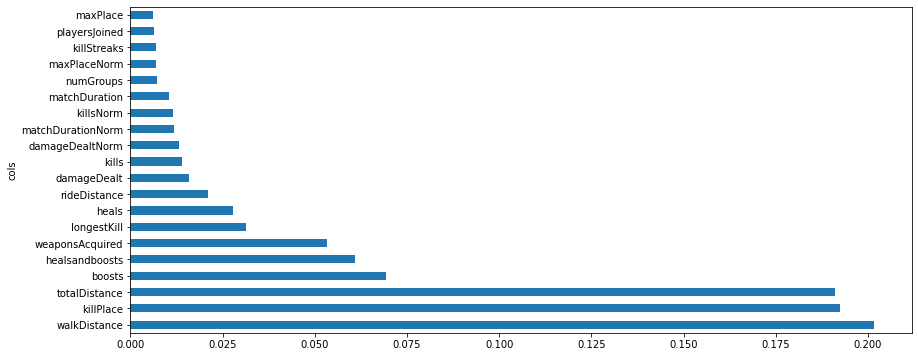

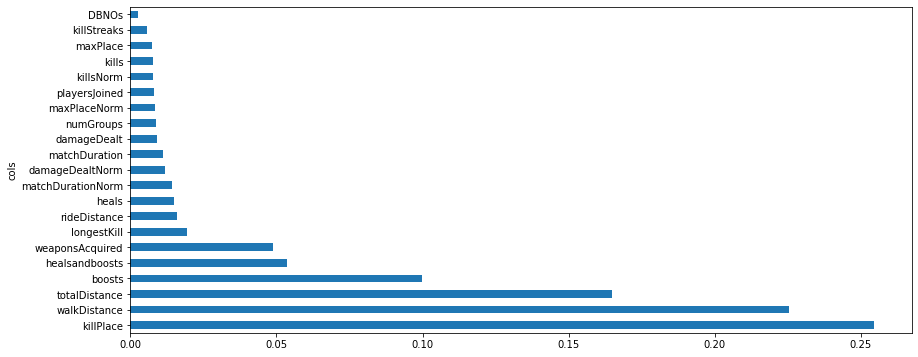

In [15]:

fi = rf_feat_importance(m1, df); fi[:10]
# Plotting a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1
# Keeping only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep
# Making a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2


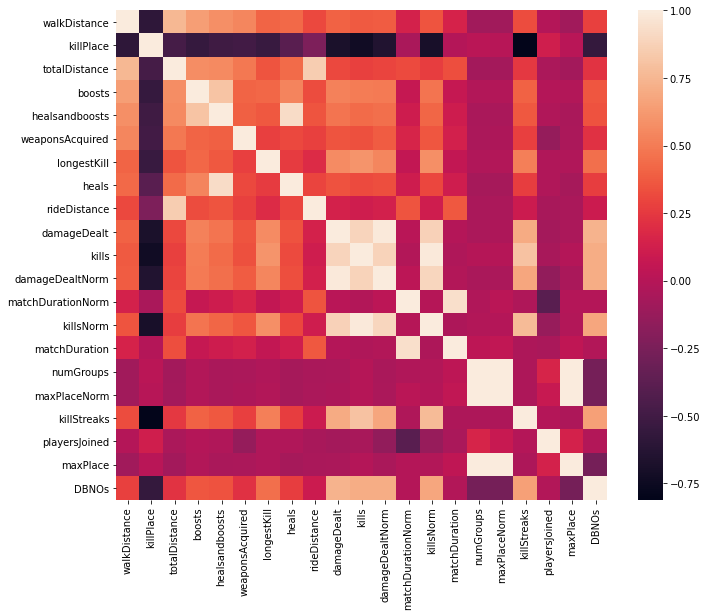

In [16]:
# Correlation heatmap
corr = df_keep.corr()
f, ax = plt.subplots(figsize=(11, 9))
heatmap = sns.heatmap(corr)



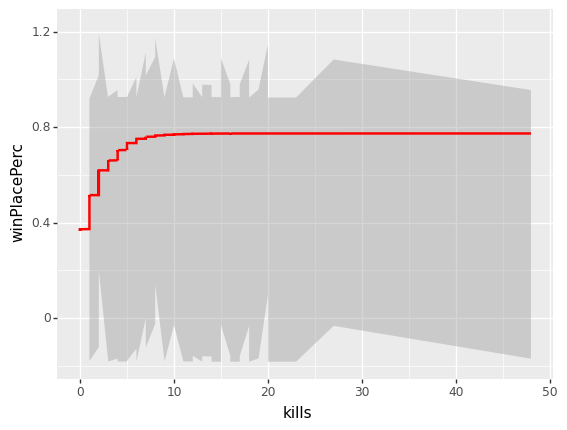

<ggplot: (-9223363302537203147)>

In [17]:
# Plot the predictive quality of kills 
x_all = get_sample(train, 100000)
ggplot(x_all, aes('kills','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')


In [0]:
# Prepare data
val_perc_full = 0.12 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)



In [19]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=3, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.03737388305834795, 'mae val: ', 0.06258677243428519]


In [20]:
# Add engineered features to the test set
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)
test['maxPlaceNorm'] = test['maxPlace']*((100-train['playersJoined'])/100 + 1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100 + 1)
test['healsandboosts'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['totalDistance'] == 0))

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

# Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()# Make submission ready for Kaggle
# We use our final Random Forest model (m3) to get the predictions
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})

# Create submission file
pred_df.to_csv("submission_V2.csv", index=False)
# Last check of submission
print('Head of submission: ')
display(pred_df.head())
print('Tail of submission: ')
display(pred_df.tail())


Head of submission: 


,Id,winPlacePerc
0,9329eb41e215eb,0.219043
1,639bd0dcd7bda8,0.868730
2,63d5c8ef8dfe91,0.715087
3,cf5b81422591d1,0.514581
4,ee6a295187ba21,0.934967


Tail of submission: 


,Id,winPlacePerc
1934169,a316c3a13887d5,0.834046
1934170,5312146b27d875,0.437627
1934171,fc8818b5b32ad3,0.904451
1934172,a0f91e35f8458f,0.823538
1934173,3696fc9f3a42b2,0.012079
